In [19]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras

from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.layers import TextVectorization

## Download the IMDb Dataset

In [20]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'train', 'imdb.vocab', 'test']

In [21]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsup',
 'pos',
 'urls_pos.txt',
 'urls_neg.txt',
 'urls_unsup.txt',
 'unsupBow.feat']

## Preparing datasets

Removing not needed directory

In [22]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Create train and validation sets 80/20% ratio

In [23]:
batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Checking data

In [24]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

## Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

- `.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Text preprocessing
Define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews

In [26]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## Create model

In [27]:
embedding_dim=16

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 


 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Compile and train the model

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tensorboard_callback])

Epoch 1/30


20/20 [==============================] - 2s 91ms/step - loss: 0.6915 - accuracy: 0.5028 - val_loss: 0.6893 - val_accuracy: 0.4886
Epoch 2/30
20/20 [==============================] - 1s 33ms/step - loss: 0.6853 - accuracy: 0.5028 - val_loss: 0.6814 - val_accuracy: 0.4886
Epoch 3/30
20/20 [==============================] - 1s 32ms/step - loss: 0.6749 - accuracy: 0.5028 - val_loss: 0.6692 - val_accuracy: 0.4886
Epoch 4/30
20/20 [==============================] - 1s 33ms/step - loss: 0.6590 - accuracy: 0.5028 - val_loss: 0.6516 - val_accuracy: 0.4886
Epoch 5/30
20/20 [==============================] - 1s 33ms/step - loss: 0.6372 - accuracy: 0.5028 - val_loss: 0.6289 - val_accuracy: 0.4886
Epoch 6/30
20/20 [==============================] - 1s 34ms/step - loss: 0.6099 - accuracy: 0.5092 - val_loss: 0.6022 - val_accuracy: 0.5268
Epoch 7/30
20/20 [==============================] - 1s 32ms/step - loss: 0.5784 - accuracy: 0.5963 - val_loss: 0.5729 - val_accuracy: 0.6096
Epoch 8/30
20/20 [======

In [29]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5164), started 0:10:51 ago. (Use '!kill 5164' to kill it.)

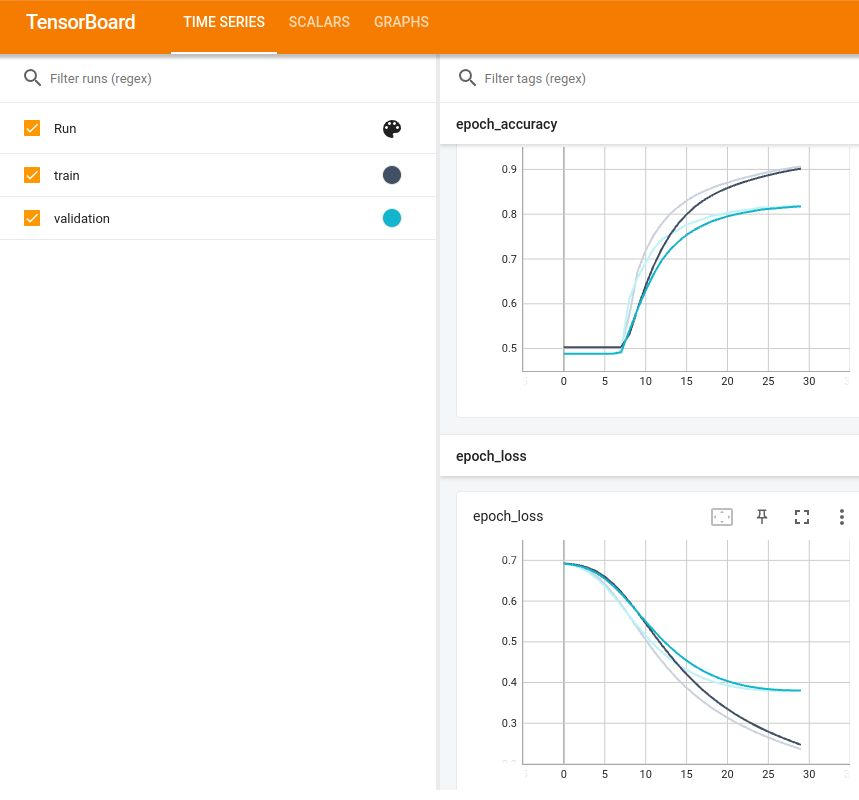

In [30]:
from IPython.display import Image
Image(filename='screen.jpg') 

## Retrieve the trained word embeddings and save

In [31]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [32]:
weights[:5]

array([[-0.04983089, -0.02630843,  0.03240674,  0.02077751,  0.06241086,
         0.09043162, -0.02818206,  0.02902222, -0.01227907, -0.03702805,
        -0.01333041,  0.06268066,  0.00670658, -0.1320323 , -0.03514477,
        -0.03624485],
       [-0.11396071, -0.07738904, -0.0298499 ,  0.10339666,  0.07620382,
         0.19612224,  0.00846987, -0.07004724, -0.00932475, -0.05782753,
        -0.09503883,  0.10057309,  0.00564647, -0.21180212, -0.07511885,
        -0.00038712],
       [-0.06748842, -0.05101133,  0.04994864,  0.04116914,  0.05547821,
         0.13891362, -0.07152935,  0.04677799,  0.03473826, -0.0734506 ,
        -0.0648677 ,  0.14397602, -0.01393982, -0.21445969, -0.03718927,
        -0.01412806],
       [ 0.02293542, -0.08557177,  0.02230074,  0.02190704,  0.06385727,
         0.1214091 , -0.1091898 ,  0.07957383,  0.10100982, -0.10103332,
         0.04903488,  0.1440133 , -0.02861417, -0.1585459 ,  0.05800138,
        -0.11016682],
       [-0.0648161 , -0.06790242,  0

In [33]:
vocab[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Write the weights to disk. To use the Embedding Projector
- a file of vectors (containing the embedding), and 
- a file of meta data (containing the words)

In [34]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

Visualized using http://projector.tensorflow.org

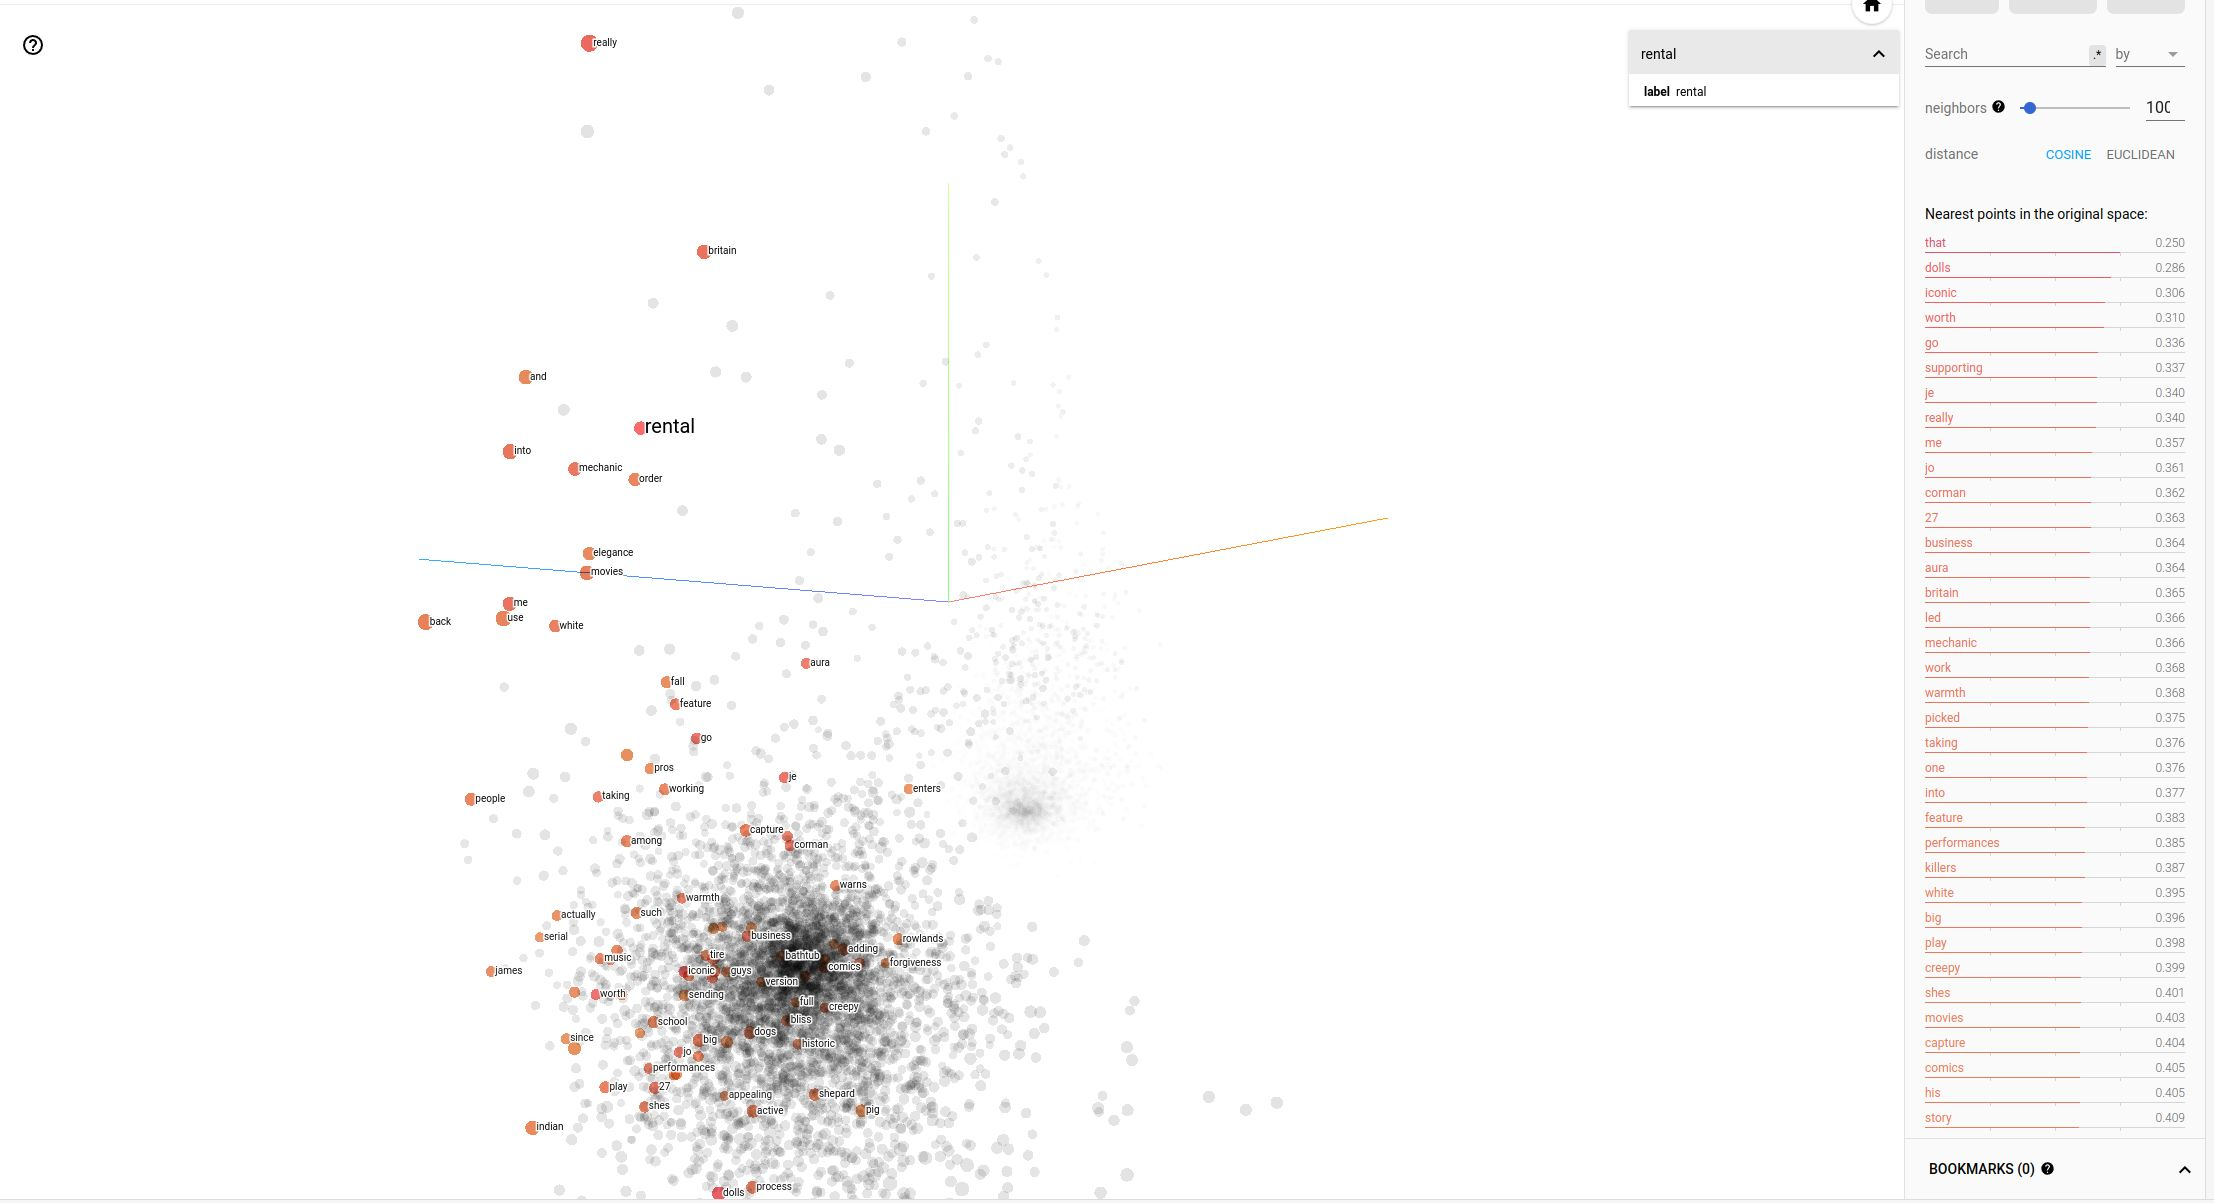

In [35]:
from IPython.display import Image
Image(filename='screen2.jpg') 